In [20]:
from gen_ai_hub.proxy.langchain.amazon import ChatBedrock
from gen_ai_hub.proxy.langchain.openai import ChatOpenAI
# llm = ChatBedrock(model_name="anthropic--claude-3-sonnet", temperature=0)
llm = ChatOpenAI(proxy_model_name="gpt-4o", temperature=0.0)

In [26]:
from langchain_core.messages import HumanMessage
import base64
import httpx
from IPython.display import HTML
from IPython.display import Image, display

def display_base64_image(encoded_image_input):
    return Image(data=base64.b64decode(encoded_image_input), format='jpeg', embed=True, width=10)

def display_images(encoded_images, width="250px"):
    images_html = ''.join([f'<img src="data:image/jpeg;base64,{img}" style="width:{width}; margin: 5px;" />' for img in encoded_images])
    display(HTML(f'''
    <div style="display: flex; flex-direction: column; gap: 10px; width: 100%;">
        {images_html}
    </div>
    '''))

# Display the base64 image
def encode_image(image_path, web):
    if web:
        return base64.b64encode(httpx.get(image_path).content).decode("utf-8")
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

# Classify Images

In [23]:
animal_image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/Domestic_cat_2019_G1.jpg/640px-Domestic_cat_2019_G1.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Cat_Sphynx._Kittens._img_11.jpg/640px-Cat_Sphynx._Kittens._img_11.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/d/dd/Chow-Chow-Canis-lupus-familiaris_2010.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/6/62/Panthera_tigris_sumatran_subspecies.jpg"
    
]
encoded_animal_imgs = [encode_image(animal_img_url, True) for animal_img_url in animal_image_urls]


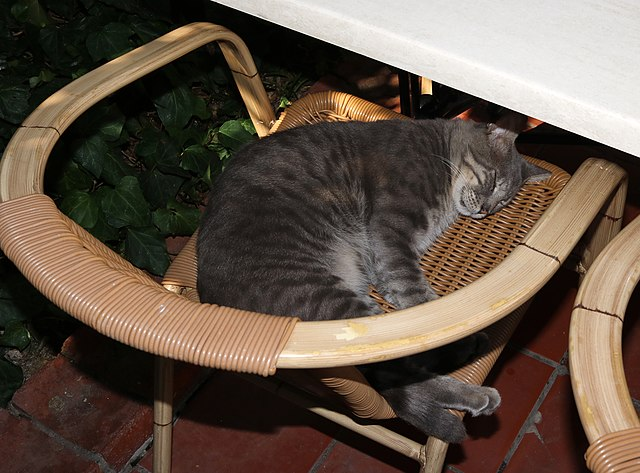
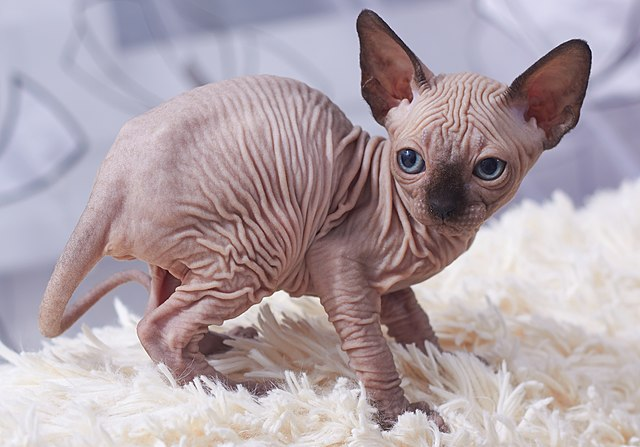
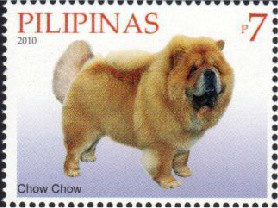
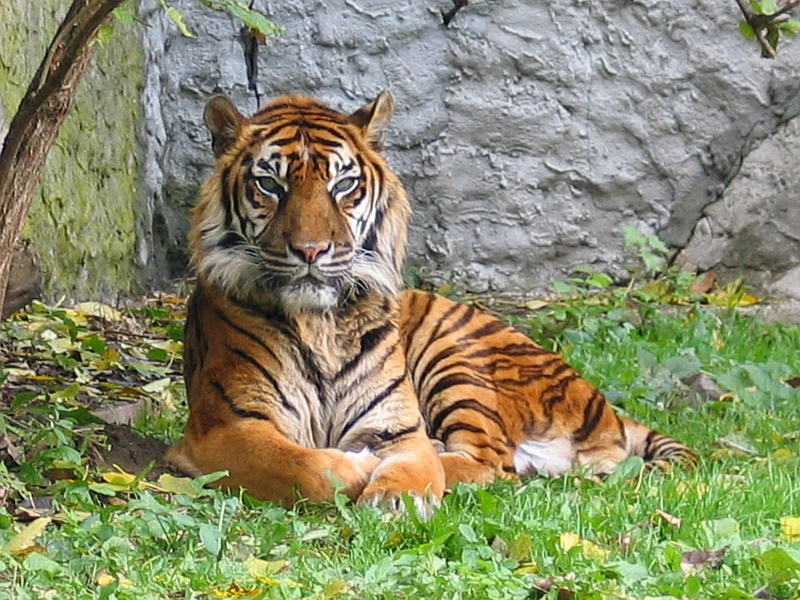

In [24]:
display_images(encoded_animal_imgs)

Processing image...
Processing image...
Processing image...
Processing image...



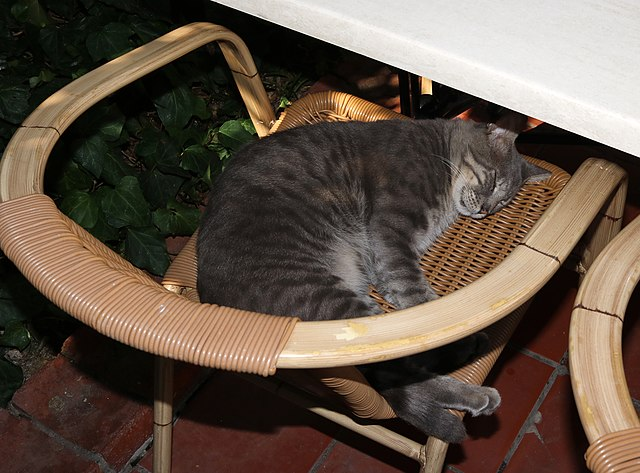
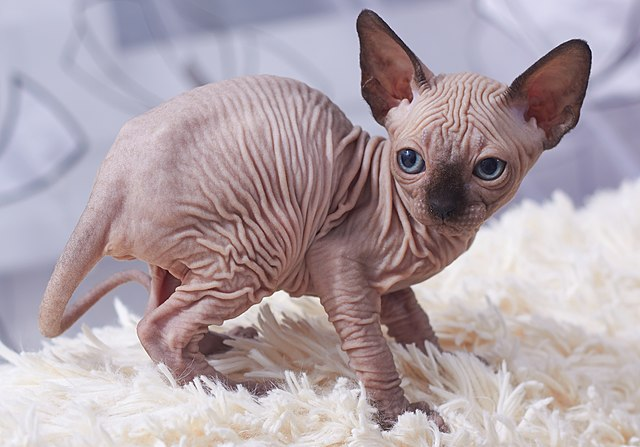
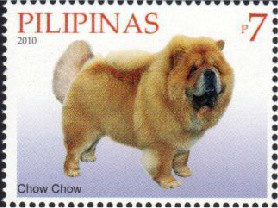
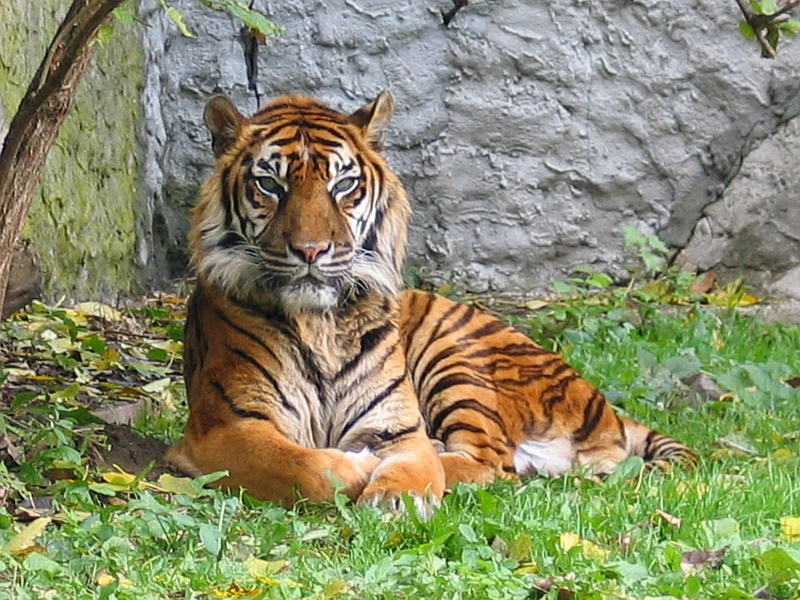

['Cat', 'Cat', 'Dog', 'Cat']


In [31]:
# classify as dog or cat exclusively. No other value allowed. Process one image at a time:
results = []
for encoded_image in encoded_animal_imgs:
    print("Processing image...")
    animal_message = HumanMessage(
        content=[
            {"type": "text", "text": """Look at the given image of an animal. Classify it as a "dog" or a "cat". Only respond with the respective class. Use whichever class is most suitable, no other classes are allowed."""},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"},
            },
        ],
    )

    animal_response = llm.invoke([animal_message])
    results.append((animal_response.content, encoded_image))
    
# print images and results
display_images([img for res, img in results])
print([res for res, img in results])


Processing image...
Processing image...
Processing image...
Processing image...



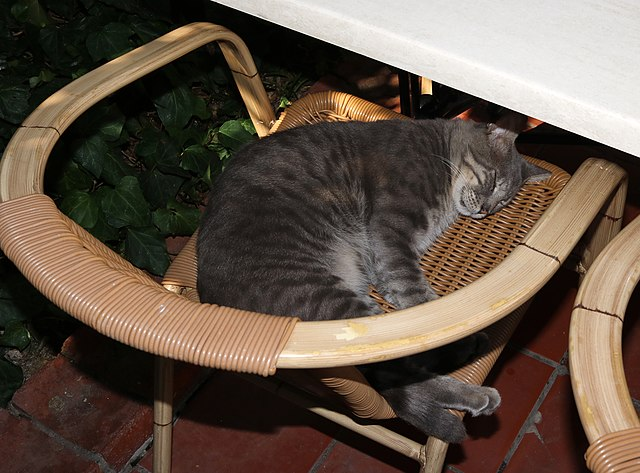
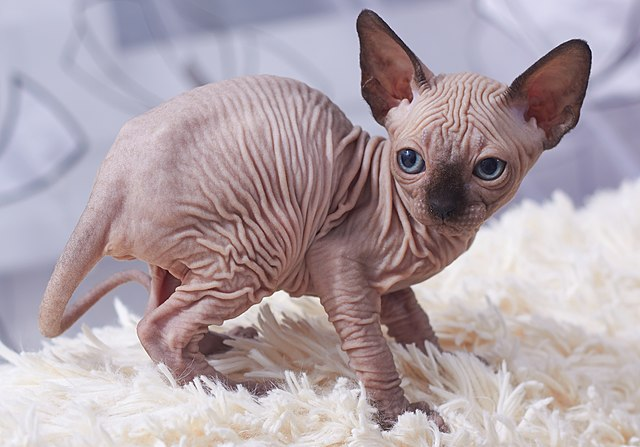
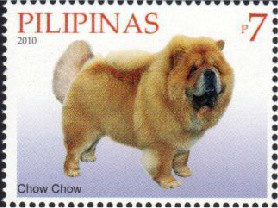
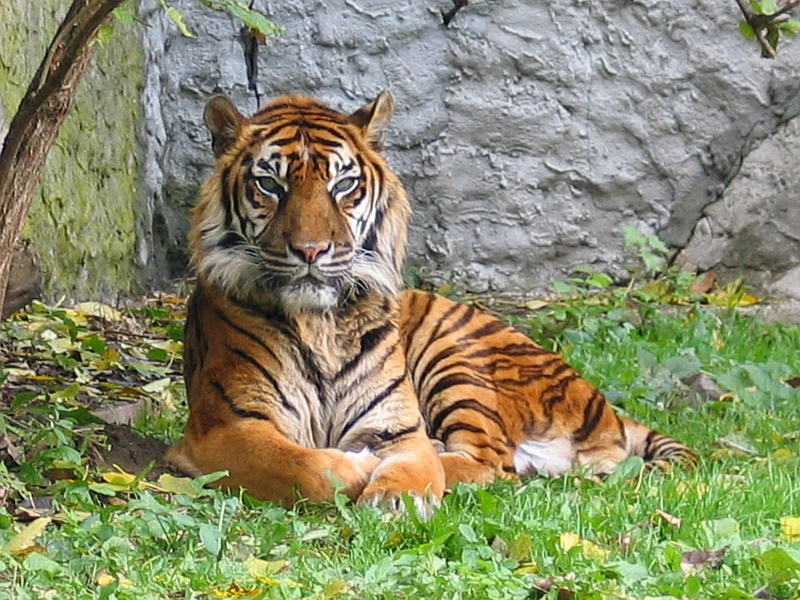

['Cat', 'Cat', 'Dog', 'Tiger']


In [32]:
# classify as dog, cat, tiger or other. No other value allowed. Process one image at a time:
results = []
for encoded_image in encoded_animal_imgs:
    print("Processing image...")
    animal_message = HumanMessage(
        content=[
            {"type": "text", "text": """Look at the given image of an animal. Classify it as a "dog", "cat", "tiger" or "other". Only respond with the respective class. Use whichever class is most suitable, no other classes are allowed."""},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"},
            },
        ],
    )

    animal_response = llm.invoke([animal_message])
    results.append((animal_response.content, encoded_image))
    
# print images and results
display_images([img for res, img in results])
print([res for res, img in results])



# Extract Structured Text from Image (Receipt)

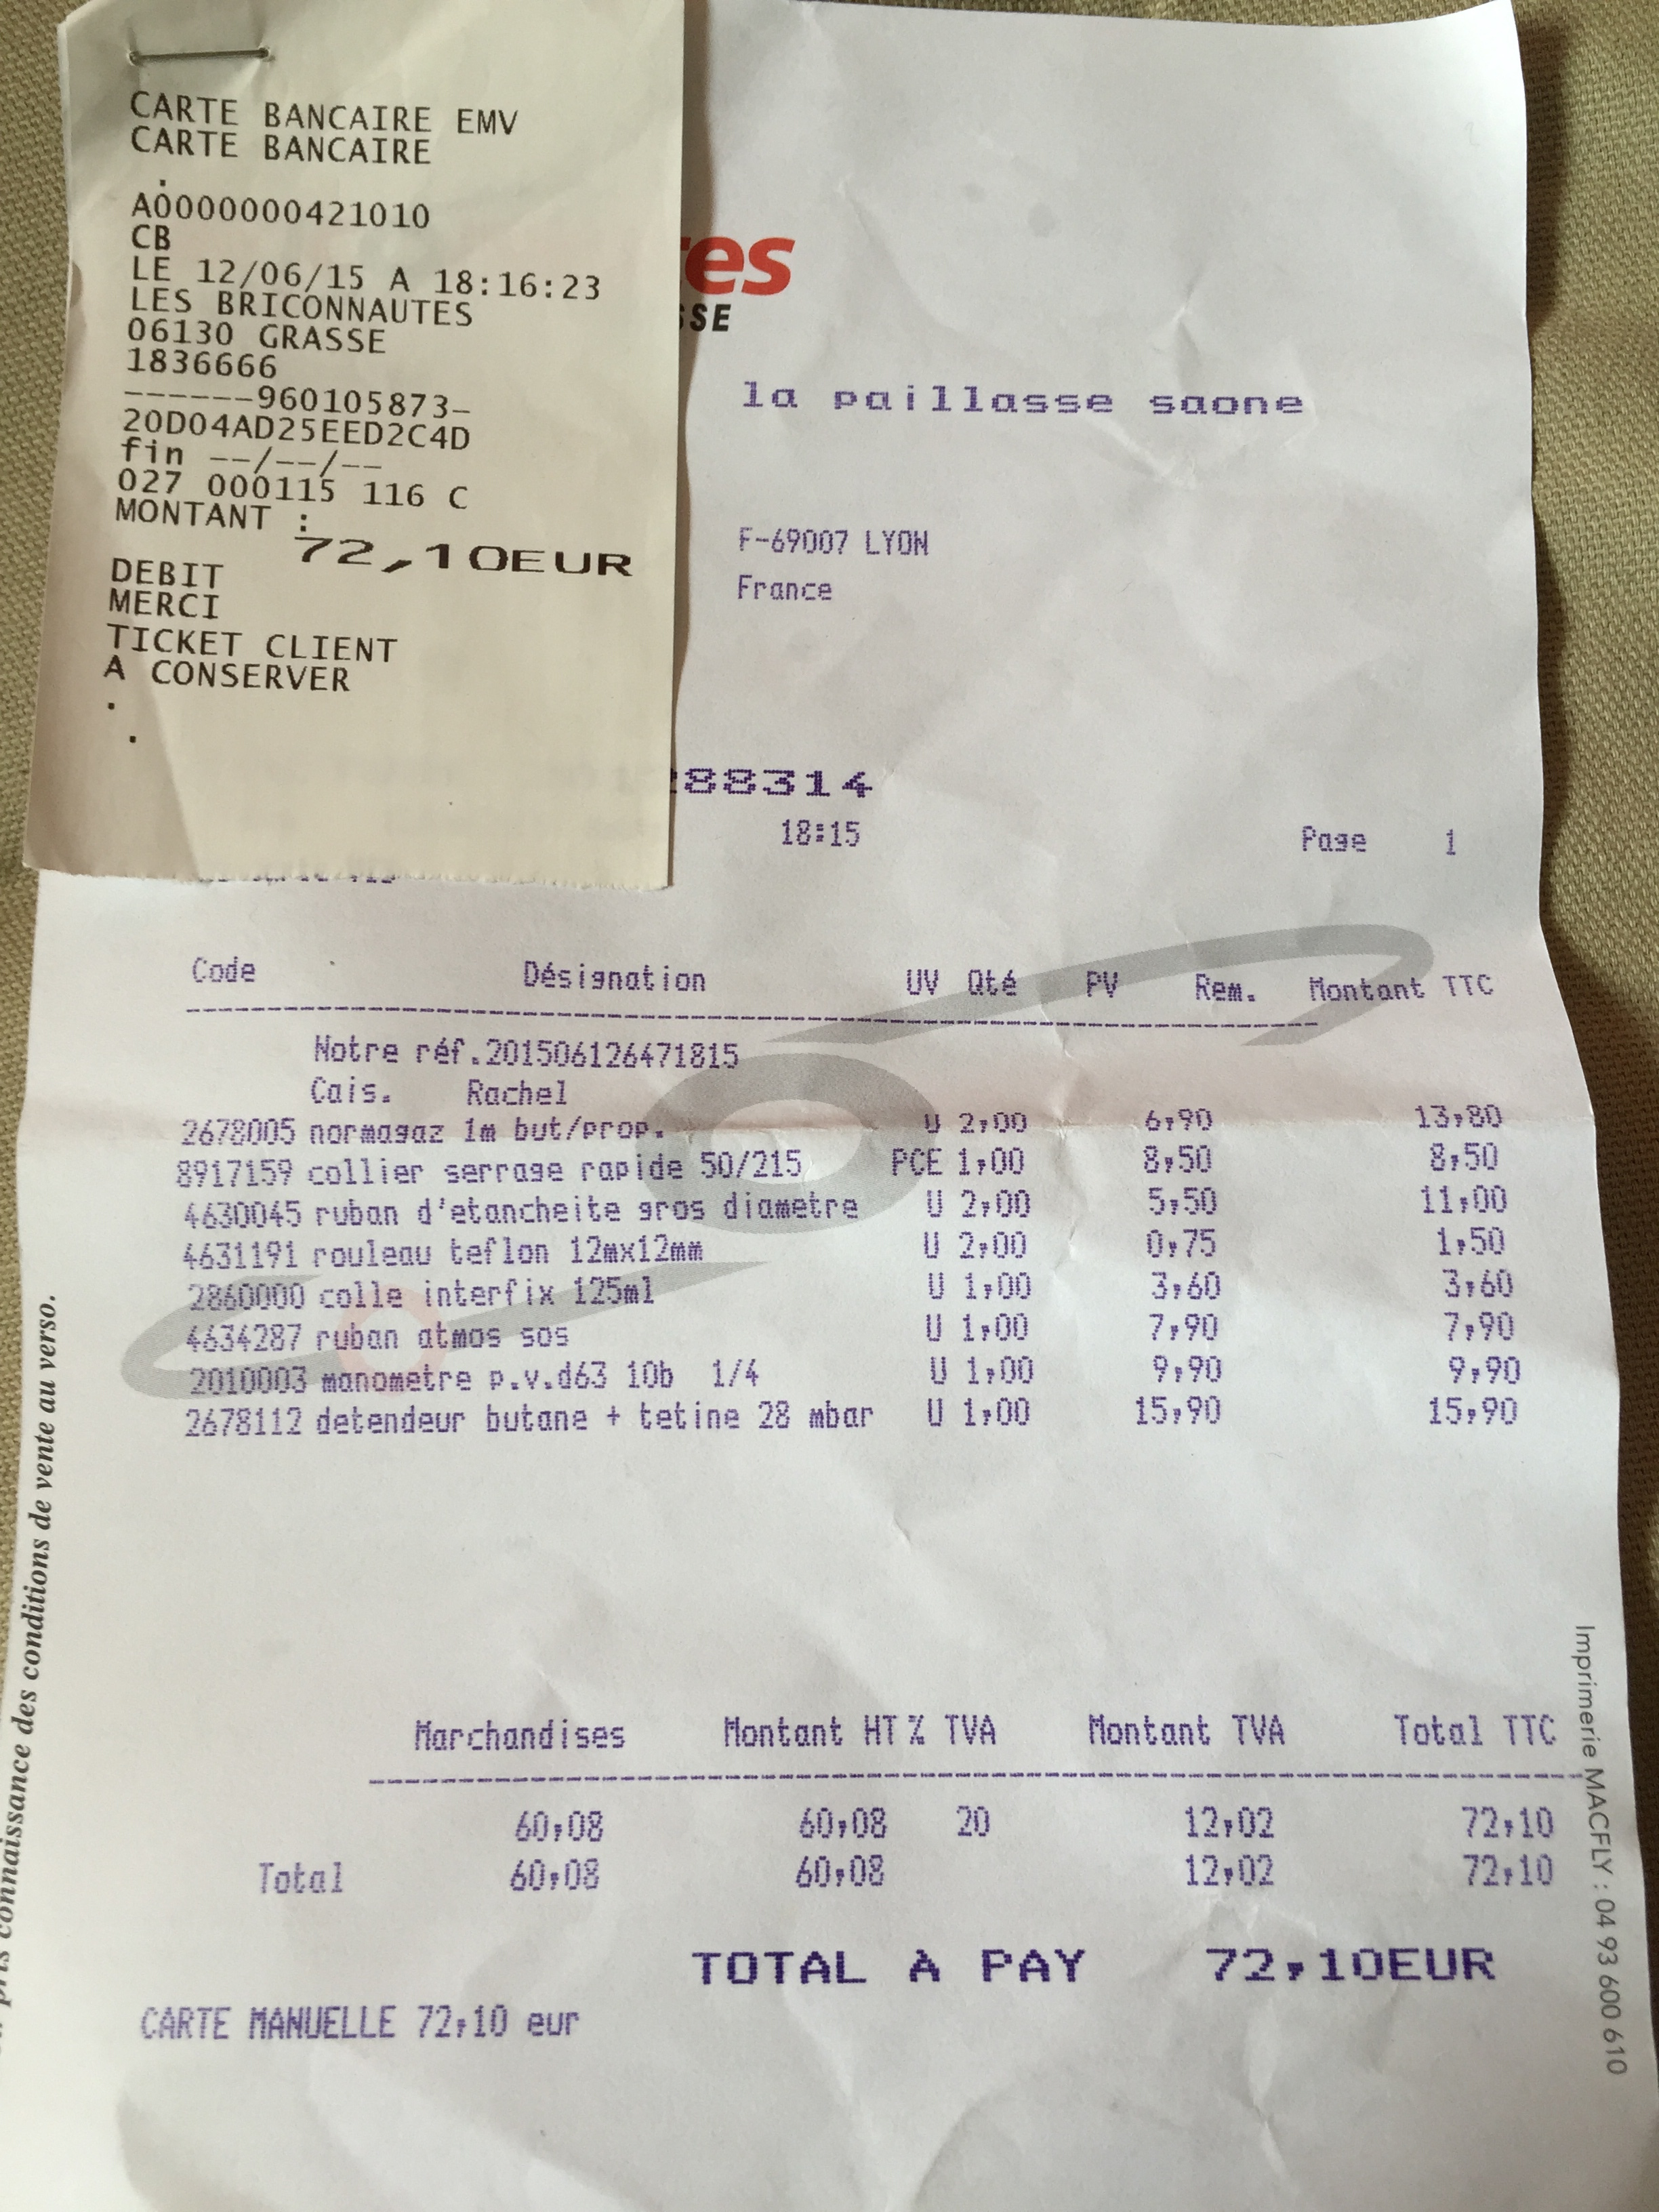

In [6]:
web_receipt_url = "https://upload.wikimedia.org/wikipedia/commons/2/24/Facture_briconaute_1.jpg"
encoded_receipt_img = encode_image(web_receipt_url, True)
display_base64_image(encoded_receipt_img, width=10)

In [8]:
receipt_message = HumanMessage(
    content=[
        {"type": "text", "text": """Look at the given image of a receipt. Extract the total amount, currency (as ISO Code), payment type ("card" or "cash") and payment date (date in format YYYY-MM-DD). Only respond with a json object in the following format, do not add the respective key if you don't find the information: {"totalAmount": float, "currency": string, "paymentType": string, "paymentDate": string}."""},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{encoded_receipt_img}"},
        },
    ],
)
receipt_response = llm.invoke([receipt_message])
print(receipt_response.content)

ValueError: Invalid input type <class 'langchain_core.messages.human.HumanMessage'>. Must be a PromptValue, str, or list of BaseMessages.

In [ ]:
from datetime import datetime
import json
try:
    json_response = json.loads(receipt_response.content)
    print("Total Amount: ", json_response.get("totalAmount", "Not Found"))
    print("Currency: ", json_response.get("currency", "Not Found"))
    print("Payment Type: ", json_response.get("paymentType", "Not Found"))
    print("Payment Date: ", datetime.strptime(json_response.get("paymentDate", "Not Found"), "%Y-%m-%d").strftime("%B %d, %Y"))
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")